# Statistical Tests

This notebook is used to perform the statistical tests as reported in the paper (in addition to a few extra ones).

In [1]:
from plot_funcs import (get_results, plot_avg_ranks, get_mean_avg_ranks, get_ranks_sizes, get_highest_performing_df, get_cut_off_df,
                        get_across_ranks, get_intra_pipeline_df, get_single_vs_multiple_df, get_model_avg_ranks, get_results_df)
from statsmodels.formula.api import ols, rlm
import numpy as np
import seaborn as sns
from scipy.stats import linregress
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display
from funcs import save_stats_summary, save_results_table

In [2]:
results = get_results('../exp/results')
static = {'random': True, 'base': True, 'fs': True, 'ico': True}

Found: 64530 Incomplete: 0


# Averaged Performance-Size Scaling

This test corresponds to Figure 2 in the manuscript, what we want to test here is the relationship between Mean Rank and size and then as further influenced by type of parcellation.

In [3]:
r_df = get_ranks_sizes(results, log=True,
                       threshold=True, **static)
model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'base_results1')
print(model.pvalues)

model.summary()

1 -13
Smallest size: 7.0
Largest size: 4000.0
Intercept                                       1.982025e-220
C(Parcellation_Type)[T.Freesurfer Extracted]     6.906313e-01
C(Parcellation_Type)[T.Icosahedron]              8.274644e-01
C(Parcellation_Type)[T.Random]                   4.040000e-08
Size                                            1.293155e-101
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     462.8
Date:                Fri, 25 Jun 2021   Prob (F-statistic):          3.57e-100
Time:                        11:37:08   Log-Likelihood:                 294.77
No. Observations:                 206   AIC:                            -579.5
Df Residuals:                     201   BIC:                            -562.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        2.6123      0.015    172.573      0.000       2.582       2.642
C(Parcellation_Type)[T.Freesurfer Extracted]     0.0167      0.042      0.399      0.691      -0.066       0.099
C(Parcellation_Type)[T.Icosahedron]             -0.0055      0.025     -0.218      0.827      -0.055       0.044
C(Parcellation_Type)[T.Random]                   0.0494      0.009      5.709      0.000       0.032       0.066
Size                                            -0.2782      0.007    -42.080      0.000      -0.291      -0.265
==============================================================================
Omnibus:                        2.407   Durbin-Watson:                   1.406
Prob(Omnibus):                  0.300   Jarque-Bera (JB):                2.234
Skew:                           0.101   Prob(JB):                        0.327
Kurtosis:                       3.469   Cond. No.                         26.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Only the difference between existing and random have enough statistical power. Viz just the different fits for Existing vs. Random:

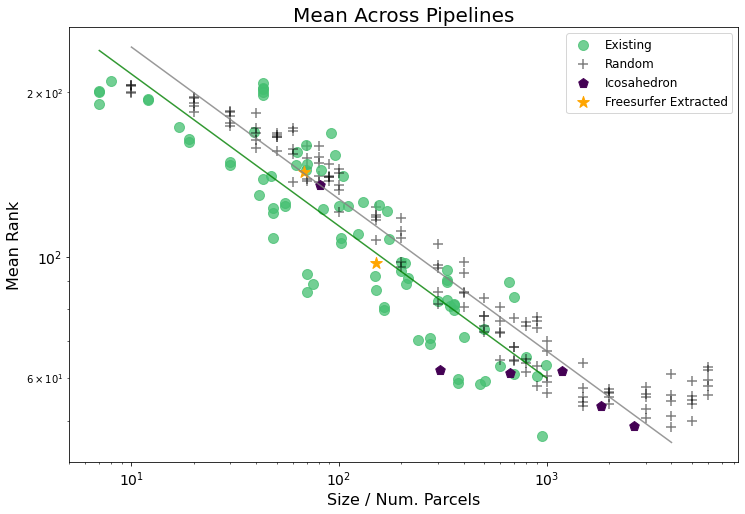

In [4]:
# Gen plot
_, ax = plt.subplots(figsize=(12, 8))

# Reverse log10 on size
e_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Existing']
r_size = 10 ** r_df['Size'][r_df['Parcellation_Type'] == 'Random']

# Get pred fit lines
e_fit = 10 ** model.params.Intercept * (e_size **(model.params.Size))

r_intercept = 10 ** (model.params.Intercept + model.params['C(Parcellation_Type)[T.Random]'])
r_fit = r_intercept * (r_size **(model.params.Size))

# Plot lines of fit
ax.plot(e_size, e_fit, color='green', alpha=.8)
ax.plot(r_size, r_fit, color='gray', alpha=.8)

# Add main plot
plot_avg_ranks(results,
               log=True,
               ax=ax, **static)

plt.savefig('Figures/base_results_fit1.png', dpi=300, bbox_inches='tight')

We want to next check if there is a possible interaction between parcellation type and size.

Intercept                                            1.146780e-169
C(Parcellation_Type)[T.Freesurfer Extracted]          3.930177e-01
C(Parcellation_Type)[T.Icosahedron]                   5.976996e-01
C(Parcellation_Type)[T.Random]                        2.141784e-01
Size                                                  3.050137e-56
Size:C(Parcellation_Type)[T.Freesurfer Extracted]     4.101729e-01
Size:C(Parcellation_Type)[T.Icosahedron]              6.135194e-01
Size:C(Parcellation_Type)[T.Random]                   7.940296e-01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     262.0
Date:                Fri, 25 Jun 2021   Prob (F-statistic):           1.85e-96
Time:                        11:37:12   Log-Likelihood:                 295.28
No. Observations:                 206   AIC:                            -574.6
Df Residuals:                     198   BIC:                            -547.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             2.6186      0.027     97.916      0.000       2.566       2.671
C(Parcellation_Type)[T.Freesurfer Extracted]          0.4179      0.488      0.856      0.393      -0.545       1.380
C(Parcellation_Type)[T.Icosahedron]                  -0.0729      0.138     -0.529      0.598      -0.345       0.199
C(Parcellation_Type)[T.Random]                        0.0411      0.033      1.246      0.214      -0.024       0.106
Size                                                 -0.2813      0.013    -22.422      0.000      -0.306      -0.257
Size:C(Parcellation_Type)[T.Freesurfer Extracted]    -0.2002      0.243     -0.825      0.410      -0.679       0.278
Size:C(Parcellation_Type)[T.Icosahedron]              0.0246      0.049      0.506      0.614      -0.071       0.121
Size:C(Parcellation_Type)[T.Random]                   0.0039      0.015      0.261      0.794      -0.025       0.033
==============================================================================
Omnibus:                        2.366   Durbin-Watson:                   1.410
Prob(Omnibus):                  0.306   Jarque-Bera (JB):                2.158
Skew:                           0.108   Prob(JB):                        0.340
Kurtosis:                       3.452   Cond. No.                         404.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

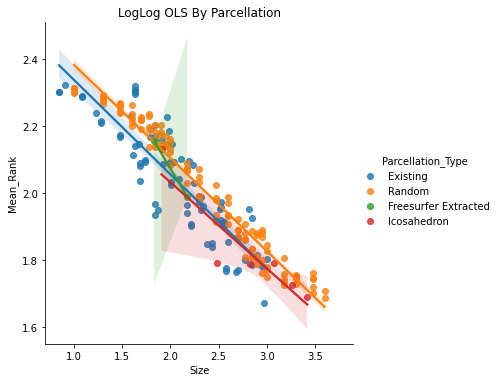

In [5]:
g = sns.lmplot(y='Mean_Rank', x='Size', data=r_df, hue='Parcellation_Type')
g.set(xlim=(.7, 3.9))

plt.title('LogLog OLS By Parcellation')
plt.savefig('Figures/base_results_fit2.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
save_stats_summary(model, 'base_results2')
print(model.pvalues)
model.summary()

No interactions are signifigant here.

Next, we will see how the results change when using robust regression and no thresholding, where thresholding = the procedure for selecting the region in which the scaling holds.

In [6]:
r_df = get_ranks_sizes(results, log=True, **static)

model = rlm('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

Intercept                                       0.000000e+00
C(Parcellation_Type)[T.Freesurfer Extracted]    6.245984e-01
C(Parcellation_Type)[T.Icosahedron]             7.260774e-01
C(Parcellation_Type)[T.Random]                  9.421043e-10
Size                                            0.000000e+00
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:              Mean_Rank   No. Observations:                  220
Model:                            RLM   Df Residuals:                      215
Method:                          IRLS   Df Model:                            4
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Fri, 25 Jun 2021                                         
Time:                        11:37:13                                         
No. Iterations:                    20                                         
================================================================================================================
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                                        2.5668      0.014    179.239      0.000       2.539       2.595
C(Parcellation_Type)[T.Freesurfer Extracted]     0.0217      0.044      0.489      0.625      -0.065       0.109
C(Parcellation_Type)[T.Icosahedron]             -0.0093      0.027     -0.350      0.726      -0.061       0.043
C(Parcellation_Type)[T.Random]                   0.0557      0.009      6.119      0.000       0.038       0.074
Size                                            -0.2580      0.006    -42.077      0.000      -0.270      -0.246
================================================================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

Let's view some specific raw results, as well as save a copy of the raw results table

In [7]:
r_df = get_ranks_sizes(results, log=False, keep_full_name=True, add_raw=True, **static)

# Show top result
display(r_df.sort_values('Mean_Rank').iloc[[0]])

# Show the two freesurfer
display(r_df[r_df['full_name'] == 'freesurfer destr'])
display(r_df[r_df['full_name'] == 'freesurfer desikan'])

# Save raw results
save_results_table(r_df, name='raw_results1')

,Parcellation_Type,Mean_Rank,Size,r2,roc_auc,full_name
194,Existing,46.888889,949,0.085201,0.629424,difumo 1024


,Parcellation_Type,Mean_Rank,Size,r2,roc_auc,full_name
11,Freesurfer Extracted,97.422222,150,0.073573,0.61954,freesurfer destr


,Parcellation_Type,Mean_Rank,Size,r2,roc_auc,full_name
10,Freesurfer Extracted,142.592593,68,0.061316,0.606063,freesurfer desikan


# Choice of Pipeline

### Intra-Pipeline Comparison

0 -16
Smallest size: 7.0
Largest size: 3000.0
0 -25
Smallest size: 7.0
Largest size: 2000.0
17 -12
Smallest size: 20.0
Largest size: 4000.0
Intercept                    0.000000e+00
C(Pipeline)[T.LGBM]          6.076915e-01
C(Pipeline)[T.SVM]           6.288269e-26
Size                        2.101406e-121
Size:C(Pipeline)[T.LGBM]     2.915962e-01
Size:C(Pipeline)[T.SVM]      3.376304e-26
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     788.0
Date:                Fri, 25 Jun 2021   Prob (F-statistic):          7.39e-257
Time:                        11:37:16   Log-Likelihood:                 733.93
No. Observations:                 590   AIC:                            -1456.
Df Residuals:                     584   BIC:                            -1430.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.5835      0.019    135.319      0.000       2.546       2.621
C(Pipeline)[T.LGBM]         -0.0135      0.026     -0.514      0.608      -0.065       0.038
C(Pipeline)[T.SVM]           0.3173      0.029     11.055      0.000       0.261       0.374
Size                        -0.2574      0.009    -30.202      0.000      -0.274      -0.241
Size:C(Pipeline)[T.LGBM]     0.0122      0.012      1.056      0.292      -0.010       0.035
Size:C(Pipeline)[T.SVM]     -0.1369      0.012    -11.123      0.000      -0.161      -0.113
==============================================================================
Omnibus:                       69.496   Durbin-Watson:                   1.488
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              104.855
Skew:                          -0.801   Prob(JB):                     1.70e-23
Kurtosis:                       4.304   Cond. No.                         39.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

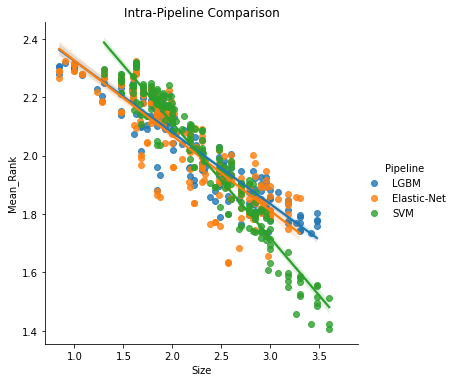

In [8]:
intra_pipe_df = get_intra_pipeline_df(results, log=True,
                                      threshold=True, **static).rename({'Model': 'Pipeline'}, axis=1)
intra_pipe_df = intra_pipe_df.replace({'lgbm': 'LGBM', 'elastic': 'Elastic-Net', 'svm':'SVM'})

# Plot
g = sns.lmplot(x='Size', y='Mean_Rank', hue='Pipeline', data=intra_pipe_df)
g.set(xlim=(.7, 3.9))
plt.title('Intra-Pipeline Comparison')
plt.savefig('Figures/intra_plot1.png', dpi=200, bbox_inches='tight')

# Run stats
model = ols('Mean_Rank ~ Size * C(Pipeline)', data=intra_pipe_df).fit()
save_stats_summary(model, 'intra_results1')
print(model.pvalues)
model.summary()

### Inter-Pipeline

Intercept                    0.000000e+00
C(Pipeline)[T.LGBM]          6.881524e-01
C(Pipeline)[T.SVM]           1.064691e-71
Size                        4.247894e-110
Size:C(Pipeline)[T.LGBM]     3.428288e-19
Size:C(Pipeline)[T.SVM]     2.267814e-106
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.921
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     1520.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:37:17   Log-Likelihood:                 742.41
No. Observations:                 660   AIC:                            -1473.
Df Residuals:                     654   BIC:                            -1446.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.8847      0.018    159.657      0.000       2.849       2.920
C(Pipeline)[T.LGBM]          0.0103      0.026      0.402      0.688      -0.040       0.060
C(Pipeline)[T.SVM]           0.5200      0.026     20.351      0.000       0.470       0.570
Size                        -0.2030      0.007    -27.297      0.000      -0.218      -0.188
Size:C(Pipeline)[T.LGBM]     0.0971      0.011      9.239      0.000       0.077       0.118
Size:C(Pipeline)[T.SVM]     -0.2800      0.011    -26.626      0.000      -0.301      -0.259
==============================================================================
Omnibus:                       28.134   Durbin-Watson:                   1.077
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.224
Skew:                          -0.408   Prob(JB):                     1.36e-08
Kurtosis:                       3.806   Cond. No.                         35.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

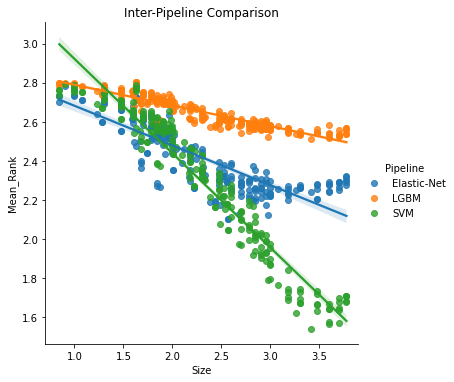

In [9]:
inter_pipe_df = get_across_ranks(results, log=True, **static).rename({'Model': 'Pipeline'}, axis=1)
inter_pipe_df = inter_pipe_df.replace({'lgbm': 'LGBM', 'elastic': 'Elastic-Net', 'svm':'SVM'})

# Plot
g = sns.lmplot(x='Size', y='Mean_Rank', hue='Pipeline', data=inter_pipe_df)
g.set(xlim=(.7, 3.9))
plt.title('Inter-Pipeline Comparison')
plt.savefig('Figures/inter_plot1.png', dpi=200, bbox_inches='tight')

model = ols('Mean_Rank ~ Size * C(Pipeline)', data=inter_pipe_df).fit()
save_stats_summary(model, 'inter_results1')
print(model.pvalues)
model.summary()

In [10]:
print('Elastic intercept vs. SVM intercept')
i = model.params.Intercept
i, i+model.params['C(Pipeline)[T.SVM]'], model.pvalues['C(Pipeline)[T.SVM]']

Elastic intercept vs. SVM intercept


(2.884716474047445, 3.404734396910803, 1.06469097951117e-71)

In [11]:
print('Elastic size coef vs. SVM interaction')
s = model.params.Size
s, s+model.params['Size:C(Pipeline)[T.SVM]'], model.pvalues['Size:C(Pipeline)[T.SVM]']

Elastic size coef vs. SVM interaction


(-0.2029570888742817, -0.4829235868733031, 2.267813520403012e-106)

# Variation Across Target Variable

Intercept    0.0
Size         0.0
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     9185.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:37:20   Log-Likelihood:                 1218.1
No. Observations:                9900   AIC:                            -2432.
Df Residuals:                    9898   BIC:                            -2418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6325      0.007    360.507      0.000       2.618       2.647
Size          -0.2880      0.003    -95.836      0.000      -0.294      -0.282
==============================================================================
Omnibus:                     3035.437   Durbin-Watson:                   1.433
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15813.941
Skew:                          -1.383   Prob(JB):                         0.00
Kurtosis:                       8.540   Cond. No.                         9.54
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

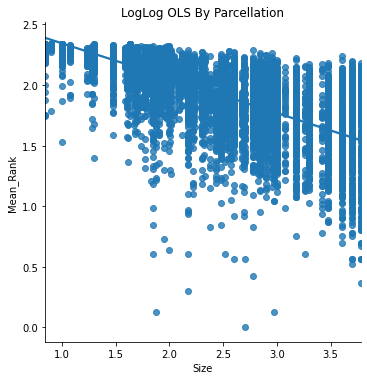

In [12]:
r_df = get_ranks_sizes(results, avg_targets=False,
                       log=True, threshold=False, **static)

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
save_stats_summary(model, 'by_target_table')
print(model.pvalues)
model.summary()

### Calculate IQR at every unique size, then fit a model explaining it in relation to size.

Intercept    1.474570e-12
Size         1.999737e-28
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    IQR   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     307.4
Date:                Fri, 25 Jun 2021   Prob (F-statistic):           2.00e-28
Time:                        11:37:20   Log-Likelihood:                 112.56
No. Observations:                  78   AIC:                            -221.1
Df Residuals:                      76   BIC:                            -216.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1987      0.023     -8.456      0.000      -0.245      -0.152
Size           0.1750      0.010     17.531      0.000       0.155       0.195
==============================================================================
Omnibus:                        7.160   Durbin-Watson:                   1.352
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                7.245
Skew:                           0.746   Prob(JB):                       0.0267
Kurtosis:                       2.966   Cond. No.                         9.86
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

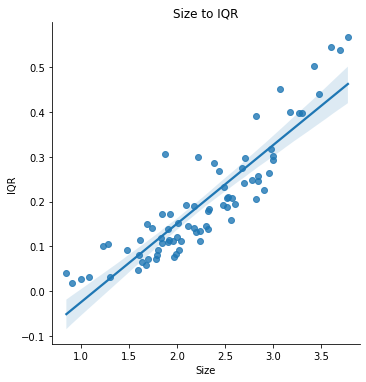

In [13]:
def v(x):
    rl = x['Mean_Rank']
    return rl.quantile(.75) - rl.quantile(.25)
    
log_size_to_var = r_df.groupby('Size').apply(v)
ls_df = log_size_to_var.to_frame().reset_index().rename(columns={0: 'IQR'})

g = sns.lmplot(y='IQR', x='Size', data=ls_df)
g.set(xlim=(.7, 3.9))
plt.title('Size to IQR')
plt.savefig('Figures/iqr.png', dpi=200, bbox_inches='tight')

model = ols('IQR ~ Size', data=ls_df).fit()
save_stats_summary(model, 'iqr_stats')
print(model.pvalues)
model.summary()

### Compare thresholded R2 at 4000 and less between variation models

Intercept    0.0
Size         0.0
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.490
Model:                            OLS   Adj. R-squared:                  0.490
Method:                 Least Squares   F-statistic:                     9082.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):               0.00
Time:                        11:37:23   Log-Likelihood:                 1745.7
No. Observations:                9450   AIC:                            -3487.
Df Residuals:                    9448   BIC:                            -3473.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6532      0.007    360.473      0.000       2.639       2.668
Size          -0.2985      0.003    -95.297      0.000      -0.305      -0.292
==============================================================================
Omnibus:                     3347.071   Durbin-Watson:                   1.539
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            21267.673
Skew:                          -1.556   Prob(JB):                         0.00
Kurtosis:                       9.658   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

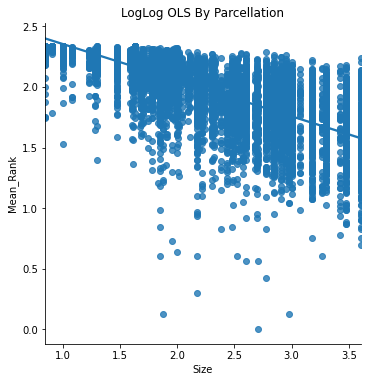

In [14]:
r_df = get_ranks_sizes(results, avg_targets=False,
                       log=True, threshold=False, **static)
r_df = r_df[r_df['Size'] <= np.log10(4000)]

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
model.summary()

Intercept    6.248435e-223
Size          8.734294e-99
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.883
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     1567.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):           8.73e-99
Time:                        11:37:24   Log-Likelihood:                 279.66
No. Observations:                 210   AIC:                            -555.3
Df Residuals:                     208   BIC:                            -548.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.6125      0.016    165.824      0.000       2.581       2.644
Size          -0.2654      0.007    -39.580      0.000      -0.279      -0.252
==============================================================================
Omnibus:                        8.075   Durbin-Watson:                   1.135
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.056
Skew:                          -0.475   Prob(JB):                       0.0178
Kurtosis:                       3.131   Cond. No.                         9.77
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

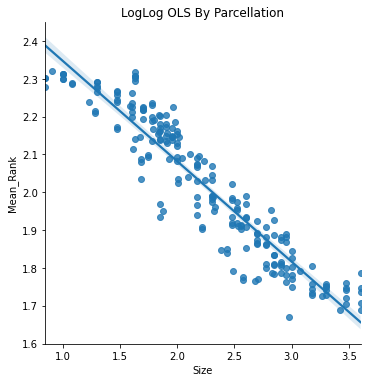

In [15]:
r_df = get_ranks_sizes(results, avg_targets=True, log=True,
                       threshold=False, **static)
r_df = r_df[r_df['Size'] <= np.log10(4000)]

sns.lmplot(y='Mean_Rank', x='Size', data=r_df)
plt.title('LogLog OLS By Parcellation')

model = ols('Mean_Rank ~ Size', data=r_df).fit()
print(model.pvalues)
model.summary()

# Single vs. Multiple Parcellations

1. Compare Ensembles to Non-Ensembled Results

Intercept                    0.000000e+00
C(is_ensemble)[T.1]          8.815286e-34
Size                        2.466520e-129
Size:C(is_ensemble)[T.1]     7.519283e-61
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     3196.
Date:                Fri, 25 Jun 2021   Prob (F-statistic):          6.51e-283
Time:                        11:37:25   Log-Likelihood:                 648.68
No. Observations:                 412   AIC:                            -1289.
Df Residuals:                     408   BIC:                            -1273.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    2.7865      0.011    248.523      0.000       2.764       2.809
C(is_ensemble)[T.1]          0.6138      0.046     13.300      0.000       0.523       0.705
Size                        -0.1638      0.005    -36.165      0.000      -0.173      -0.155
Size:C(is_ensemble)[T.1]    -0.2804      0.014    -19.621      0.000      -0.308      -0.252
==============================================================================
Omnibus:                       12.337   Durbin-Watson:                   0.987
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               16.195
Skew:                          -0.276   Prob(JB):                     0.000304
Kurtosis:                       3.800   Cond. No.                         63.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

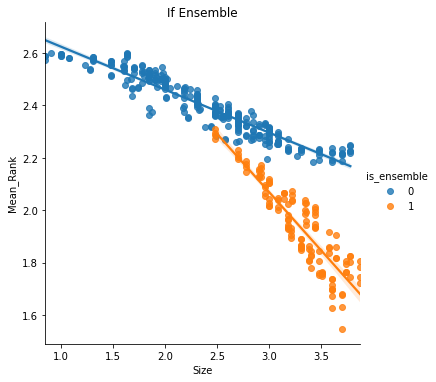

In [16]:
r_df = get_single_vs_multiple_df(results, threshold=False, log=True,
                                 stacked=True,
                                 voted=True, grid=True,
                                 **static).reset_index()
# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='is_ensemble', data=r_df)
plt.title('If Ensemble')

model = ols('Mean_Rank ~ Size * C(is_ensemble)', data=r_df).fit()
print(model.pvalues)
model.summary()

In [22]:
sum(r_df['Parcellation_Type'] == 'Voted')

64

In [25]:
64 * 3

192

In [18]:
412 - 220

192

In [19]:
192 / 3

64.0

In [17]:
model.params.Intercept, model.params.Intercept + model.params['C(is_ensemble)[T.1]'], model.pvalues['C(is_ensemble)[T.1]']

(2.7864641501326712, 3.4002807870363334, 8.815285942121511e-34)

In [18]:
model.params.Size, model.params.Size + model.params['Size:C(is_ensemble)[T.1]'], model.pvalues['Size:C(is_ensemble)[T.1]']

(-0.16376141839751493, -0.44416712197703656, 7.519282628138434e-61)

2. Compare Stacked vs. Voted Results

Intercept                        1.576421e-80
C(Parcellation_Type)[T.Voted]    3.199006e-01
Size                             1.033708e-39
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     190.5
Date:                Thu, 24 Jun 2021   Prob (F-statistic):           1.12e-38
Time:                        13:38:46   Log-Likelihood:                 153.52
No. Observations:                 128   AIC:                            -301.0
Df Residuals:                     125   BIC:                            -292.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         3.0516      0.066     46.289      0.000       2.921       3.182
C(Parcellation_Type)[T.Voted]     0.0130      0.013      0.999      0.320      -0.013       0.039
Size                             -0.3872      0.020    -19.494      0.000      -0.426      -0.348
==============================================================================
Omnibus:                        4.165   Durbin-Watson:                   0.922
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                3.461
Skew:                          -0.299   Prob(JB):                        0.177
Kurtosis:                       2.461   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

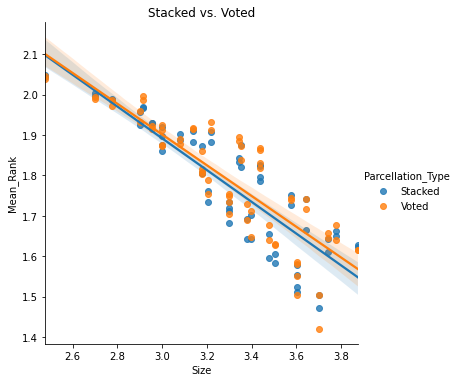

In [19]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False)

sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=r_df)
plt.title('Stacked vs. Voted')

model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

Make sure allowing for interactions is also not signifgant

In [20]:
model = ols('Mean_Rank ~ Size * C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

Intercept                             2.994607e-63
C(Parcellation_Type)[T.Voted]         8.304037e-01
Size                                  3.412065e-27
Size:C(Parcellation_Type)[T.Voted]    7.531906e-01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.753
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     126.1
Date:                Thu, 24 Jun 2021   Prob (F-statistic):           1.66e-37
Time:                        13:38:46   Log-Likelihood:                 153.57
No. Observations:                 128   AIC:                            -299.1
Df Residuals:                     124   BIC:                            -287.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Intercept                              3.0722      0.093     32.996      0.000       2.888       3.257
C(Parcellation_Type)[T.Voted]         -0.0283      0.132     -0.215      0.830      -0.289       0.232
Size                                  -0.3935      0.028    -13.957      0.000      -0.449      -0.338
Size:C(Parcellation_Type)[T.Voted]     0.0126      0.040      0.315      0.753      -0.066       0.091
==============================================================================
Omnibus:                        3.897   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.143   Jarque-Bera (JB):                3.346
Skew:                          -0.301   Prob(JB):                        0.188
Kurtosis:                       2.485   Cond. No.                         94.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

3. Compare fixed size ensemble to across size ensemble

Intercept               6.877302e-116
C(across_sizes)[T.1]     1.875436e-37
Size                     3.525973e-75
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     870.8
Date:                Thu, 24 Jun 2021   Prob (F-statistic):           4.14e-74
Time:                        13:38:47   Log-Likelihood:                 237.06
No. Observations:                 128   AIC:                            -468.1
Df Residuals:                     125   BIC:                            -459.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.2758      0.036     90.641      0.000       3.204       3.347
C(across_sizes)[T.1]     0.1409      0.008     18.433      0.000       0.126       0.156
Size                    -0.4695      0.011    -41.680      0.000      -0.492      -0.447
==============================================================================
Omnibus:                        4.198   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.123   Jarque-Bera (JB):                3.970
Skew:                          -0.431   Prob(JB):                        0.137
Kurtosis:                       3.021   Cond. No.                         38.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

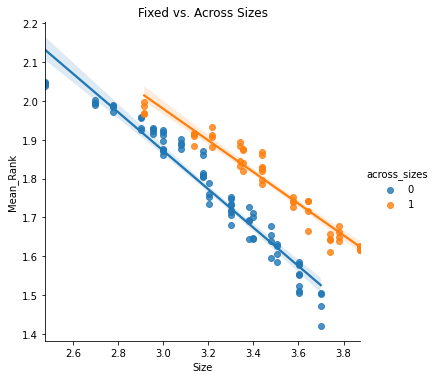

In [21]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, by_group=False)
r_df['across_sizes'] = [1 if '-' in r else 0 for r in r_df.index]

sns.lmplot(x='Size', y='Mean_Rank', hue='across_sizes', data=r_df)
plt.title('Fixed vs. Across Sizes')

model = ols('Mean_Rank ~ Size + C(across_sizes)', data=r_df).fit()
print(model.pvalues)
model.summary()

Check for size interactions on only a subset where they start at the same size

Intercept                    9.986308e-97
C(across_sizes)[T.1]         1.551295e-08
Size                         1.160429e-66
Size:C(across_sizes)[T.1]    9.757550e-13
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     753.0
Date:                Thu, 24 Jun 2021   Prob (F-statistic):           4.78e-74
Time:                        13:38:47   Log-Likelihood:                 245.31
No. Observations:                 116   AIC:                            -482.6
Df Residuals:                     112   BIC:                            -471.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     3.6551      0.050     73.676      0.000       3.557       3.753
C(across_sizes)[T.1]         -0.4509      0.074     -6.100      0.000      -0.597      -0.304
Size                         -0.5839      0.015    -38.705      0.000      -0.614      -0.554
Size:C(across_sizes)[T.1]     0.1759      0.022      8.048      0.000       0.133       0.219
==============================================================================
Omnibus:                        0.105   Durbin-Watson:                   1.866
Prob(Omnibus):                  0.949   Jarque-Bera (JB):                0.260
Skew:                           0.042   Prob(JB):                        0.878
Kurtosis:                       2.784   Cond. No.                         122.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

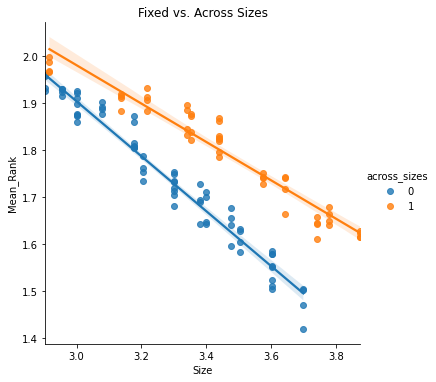

In [22]:
r_df = get_ranks_sizes(results, stacked=True,
                       voted=True, log=True,
                       threshold=False, by_group=False)
r_df['across_sizes'] = [1 if '-' in r else 0 for r in r_df.index]
r_df = r_df[r_df['Size'] > 2.9]

sns.lmplot(x='Size', y='Mean_Rank', hue='across_sizes', data=r_df)
plt.title('Fixed vs. Across Sizes')

model = ols('Mean_Rank ~ Size * C(across_sizes)', data=r_df).fit()
print(model.pvalues)
model.summary()

4. Compare ‘Grid’ results to just random single parcellation results

restrict to: 100 1200
Intercept                         8.717259e-122
C(Parcellation_Type)[T.Random]     9.415719e-01
Size                               1.151680e-63
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     617.2
Date:                Thu, 24 Jun 2021   Prob (F-statistic):           1.49e-62
Time:                        13:38:48   Log-Likelihood:                 243.21
No. Observations:                 119   AIC:                            -480.4
Df Residuals:                     116   BIC:                            -472.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          2.7432      0.024    115.943      0.000       2.696       2.790
C(Parcellation_Type)[T.Random]     0.0004      0.006      0.073      0.942      -0.011       0.012
Size                              -0.3143      0.009    -35.133      0.000      -0.332      -0.297
==============================================================================
Omnibus:                        1.385   Durbin-Watson:                   2.158
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                1.303
Skew:                          -0.253   Prob(JB):                        0.521
Kurtosis:                       2.916   Cond. No.                         24.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

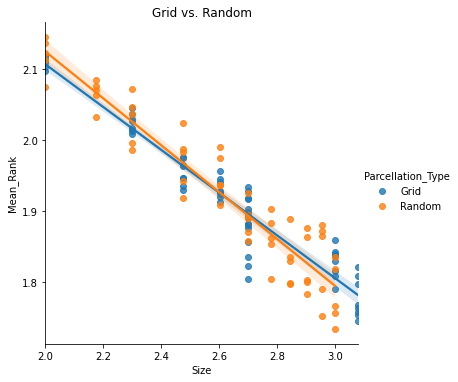

In [23]:
r_df = get_ranks_sizes(results, grid=True, random=True,
                       threshold=False, by_group=True, log=True)

# Get only random parcellations of the same size
g_sizes = r_df[r_df['Parcellation_Type'] == 'Grid']['Size']
g_max = g_sizes.max()
g_min = g_sizes.min()
print('restrict to:', round(10 ** g_min), round(10 ** g_max))
r_df = r_df[(r_df['Size'] >= g_min) & (r_df['Size'] <= g_max)]

sns.lmplot(x='Size', y='Mean_Rank', hue='Parcellation_Type', data=r_df)
plt.title('Grid vs. Random')

model = ols('Mean_Rank ~ Size + C(Parcellation_Type)', data=r_df).fit()
print(model.pvalues)
model.summary()

# Highest Performance

 Inter pipeline ensemble results, to show that SVM based ensembles outperform other pipelines, use as justification for including them in Figure 6.

Intercept                6.869816e-166
C(Model)[T.lgbm]          6.050027e-10
C(Model)[T.svm]           1.467797e-15
Size                      3.070528e-25
Size:C(Model)[T.lgbm]     2.275896e-08
Size:C(Model)[T.svm]      9.546396e-22
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.828
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     364.3
Date:                Thu, 24 Jun 2021   Prob (F-statistic):          4.23e-142
Time:                        13:38:49   Log-Likelihood:                 490.90
No. Observations:                 384   AIC:                            -969.8
Df Residuals:                     378   BIC:                            -946.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.9596      0.060     49.020      0.000       2.841       3.078
C(Model)[T.lgbm]          0.5425      0.085      6.354      0.000       0.375       0.710
C(Model)[T.svm]           0.7116      0.085      8.334      0.000       0.544       0.879
Size                     -0.2042      0.018    -11.173      0.000      -0.240      -0.168
Size:C(Model)[T.lgbm]    -0.1476      0.026     -5.711      0.000      -0.198      -0.097
Size:C(Model)[T.svm]     -0.2637      0.026    -10.201      0.000      -0.315      -0.213
==============================================================================
Omnibus:                        3.229   Durbin-Watson:                   0.900
Prob(Omnibus):                  0.199   Jarque-Bera (JB):                2.615
Skew:                           0.082   Prob(JB):                        0.270
Kurtosis:                       2.630   Cond. No.                         135.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

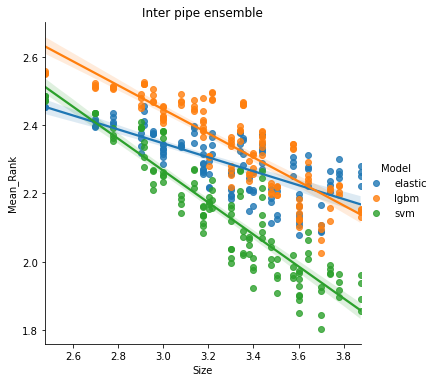

In [24]:
inter_pipe_df = get_across_ranks(results, drop_all=True,
                                 log=True, stacked=True, voted=True)

# Plot
sns.lmplot(x='Size', y='Mean_Rank', hue='Model', data=inter_pipe_df)
plt.title('Inter pipe ensemble')

# Model
model = ols('Mean_Rank ~ Size * C(Model)', data=inter_pipe_df).fit()
print(model.pvalues)
model.summary()

61 None
Smallest size: 273
Largest size: 5000
Intercept               6.700933e-159
C(Model)[T.existing]     1.275548e-06
C(Model)[T.svm]          1.702110e-27
Size                     3.995918e-95
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Mean_Rank   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     794.6
Date:                Thu, 24 Jun 2021   Prob (F-statistic):          2.15e-105
Time:                        13:38:50   Log-Likelihood:                 317.14
No. Observations:                 189   AIC:                            -626.3
Df Residuals:                     185   BIC:                            -613.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.2985      0.035     94.958      0.000       3.230       3.367
C(Model)[T.existing]     0.0553      0.011      5.008      0.000       0.034       0.077
C(Model)[T.svm]          0.0930      0.007     12.874      0.000       0.079       0.107
Size                    -0.4443      0.011    -41.194      0.000      -0.466      -0.423
==============================================================================
Omnibus:                        0.148   Durbin-Watson:                   1.359
Prob(Omnibus):                  0.928   Jarque-Bera (JB):                0.151
Skew:                           0.064   Prob(JB):                        0.927
Kurtosis:                       2.949   Cond. No.                         36.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

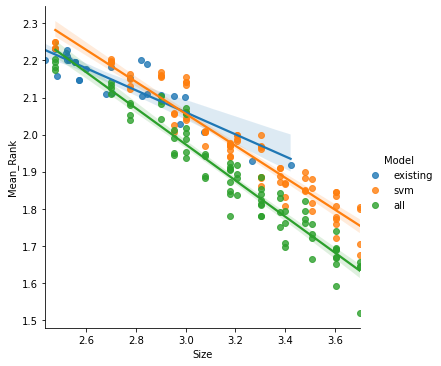

In [25]:
# get DF
r_df = get_highest_performing_df(results)

# Do Threshold
r_df = get_cut_off_df(r_df)
print('Smallest size:', r_df.sort_values('Size').iloc[0].Size)
print('Largest size:', r_df.sort_values('Size').iloc[-1].Size)

# Setup for plot
r_df = r_df.reset_index()
r_df['Mean_Rank'] = np.log10(r_df['Mean_Rank'])
r_df['Size'] = np.log10(r_df['Size'])

sns.lmplot(y='Mean_Rank', x='Size', data=r_df, hue='Model')

# Model
model = ols('Mean_Rank ~ Size + C(Model)', data=r_df).fit()
print(model.pvalues)
model.summary()